# Project 3: Gender Name Classifier

This notebook follows Exercise 6.10.2 from *Natural Language Processing with Python*. The goal is to build a gender classifier using NLTK's Names Corpus and incrementally improve it using various features and classifiers. I'll compare three different classifiers:

1. Naive Bayes Classifier
2. Decision Tree Classifier
3. Random Forest Classifier

Each classifier will be evaluated on the same dataset to compare their performance.

In [23]:
import random
import nltk
from nltk.corpus import names
from nltk import NaiveBayesClassifier, classify
from nltk.classify import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
nltk.download('names')

[nltk_data] Downloading package names to
[nltk_data]     /Users/amishrasheed/nltk_data...
[nltk_data]   Package names is already up-to-date!


True

In [24]:
# Load names and label them
labeled_names = [(name, 'male') for name in names.words('male.txt')] + \
                 [(name, 'female') for name in names.words('female.txt')]
random.shuffle(labeled_names)

# Split the data
test_names = labeled_names[:500]
devtest_names = labeled_names[500:1000]
train_names = labeled_names[1000:]


## 1. Naive Bayes Classifier

The Naive Bayes classifier is a probabilistic classifier based on Bayes' theorem. It assumes that features are conditionally independent given the class label. Despite this 'naive' assumption, it often performs surprisingly well in practice, especially for text classification tasks. In our case, it uses the probability of certain features (like last letter) occurring in male vs. female names to make predictions.

### Baseline Implementation
 Start with a simple feature set using just the last letter of the name.

In [25]:
# Baseline feature extractor
def gender_features(word):
    return {'last_letter': word[-1]}

# Feature sets
train_set = [(gender_features(n), gender) for (n, gender) in train_names]
devtest_set = [(gender_features(n), gender) for (n, gender) in devtest_names]
test_set = [(gender_features(n), gender) for (n, gender) in test_names]

# Train and evaluate
classifier = NaiveBayesClassifier.train(train_set)
print("Accuracy on devtest set:", classify.accuracy(classifier, devtest_set))

Accuracy on devtest set: 0.766


### Feature Improvement
Enhance the feature set by including more characteristics of the names:
- Last letter
- Last two letters
- First letter
- Name length
- Vowel count

In [26]:
def gender_features2(name):
    features = {}
    features['last_letter'] = name[-1].lower()
    features['last_two'] = name[-2:].lower()
    features['first_letter'] = name[0].lower()
    features['name_length'] = len(name)
    features['vowel_count'] = sum(1 for c in name.lower() if c in 'aeiou')
    return features

train_set2 = [(gender_features2(n), gender) for (n, gender) in train_names]
devtest_set2 = [(gender_features2(n), gender) for (n, gender) in devtest_names]
test_set2 = [(gender_features2(n), gender) for (n, gender) in test_names]

classifier2 = NaiveBayesClassifier.train(train_set2)
print("Improved accuracy on devtest set:", classify.accuracy(classifier2, devtest_set2))
classifier2.show_most_informative_features(10)

Improved accuracy on devtest set: 0.782
Most Informative Features
                last_two = 'na'           female : male   =    156.1 : 1.0
                last_two = 'la'           female : male   =     70.5 : 1.0
                last_two = 'rt'             male : female =     47.9 : 1.0
                last_two = 'ia'           female : male   =     35.2 : 1.0
                last_two = 'ra'           female : male   =     35.0 : 1.0
                last_two = 'sa'           female : male   =     34.1 : 1.0
             last_letter = 'a'            female : male   =     33.3 : 1.0
             last_letter = 'k'              male : female =     30.0 : 1.0
                last_two = 'us'             male : female =     26.7 : 1.0
                last_two = 'do'             male : female =     24.8 : 1.0


### Further Feature Improvements
Enhance the feature set further by adding:
- Consonant patterns (common consonant combinations)
- Syllable count estimation
- Common name endings

In [27]:
def count_syllables(name):
    # Simple syllable counting based on vowels
    name = name.lower()
    count = 0
    vowels = 'aeiouy'
    name = name.rstrip(vowels)
    for i in range(len(name)-1):
        if name[i] in vowels and name[i+1] not in vowels:
            count += 1
    return count

def gender_features3(name):
    features = gender_features2(name)
    name = name.lower()
    
    # Add consonant patterns
    features['has_br'] = 'br' in name
    features['has_ch'] = 'ch' in name
    features['has_ph'] = 'ph' in name
    features['has_sh'] = 'sh' in name
    features['has_th'] = 'th' in name
    
    # Add syllable count
    features['syllable_count'] = count_syllables(name)
    
    # Add common endings
    features['ends_ie'] = name.endswith('ie')
    features['ends_ey'] = name.endswith('ey')
    features['ends_er'] = name.endswith('er')
    features['ends_or'] = name.endswith('or')
    
    return features

train_set3 = [(gender_features3(n), gender) for (n, gender) in train_names]
devtest_set3 = [(gender_features3(n), gender) for (n, gender) in devtest_names]
test_set3 = [(gender_features3(n), gender) for (n, gender) in test_names]

classifier3 = NaiveBayesClassifier.train(train_set3)
print("Accuracy with additional features on devtest set:", classify.accuracy(classifier3, devtest_set3))
print("Accuracy with additional features on test set:", classify.accuracy(classifier3, test_set3))
classifier3.show_most_informative_features(10)

Accuracy with additional features on devtest set: 0.782
Accuracy with additional features on test set: 0.774
Most Informative Features
                last_two = 'na'           female : male   =    156.1 : 1.0
                last_two = 'la'           female : male   =     70.5 : 1.0
                last_two = 'rt'             male : female =     47.9 : 1.0
                last_two = 'ia'           female : male   =     35.2 : 1.0
                last_two = 'ra'           female : male   =     35.0 : 1.0
                last_two = 'sa'           female : male   =     34.1 : 1.0
             last_letter = 'a'            female : male   =     33.3 : 1.0
             last_letter = 'k'              male : female =     30.0 : 1.0
                last_two = 'us'             male : female =     26.7 : 1.0
                last_two = 'do'             male : female =     24.8 : 1.0


## 2. Decision Tree Classifier

The Decision Tree classifier creates a tree-like model of decisions based on feature values. Each internal node represents a feature, each branch represents a decision rule, and each leaf node represents an outcome (male or female in our case). This classifier is particularly good at capturing non-linear relationships in the data and is easily interpretable. It works by recursively splitting the data based on feature values that best separate the classes.

In [28]:
# Train Decision Tree Classifier
dt_classifier = DecisionTreeClassifier.train(train_set2)
print("Decision Tree accuracy on devtest set:", classify.accuracy(dt_classifier, devtest_set2))
print("Decision Tree accuracy on test set:", classify.accuracy(dt_classifier, test_set2))

Decision Tree accuracy on devtest set: 0.788
Decision Tree accuracy on test set: 0.75


## 3. Random Forest Classifier

The Random Forest classifier is an ensemble method that builds multiple decision trees and combines their predictions. Each tree is trained on a random subset of the data and features, which helps prevent overfitting. The final prediction is made by majority voting among all trees. This approach often provides better generalization than individual decision trees and is less prone to overfitting.

In [29]:
# Convert feature dictionaries to feature vectors
vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform([f for f, _ in train_set2])
X_test = vectorizer.transform([f for f, _ in test_set2])
y_train = [label for _, label in train_set2]
y_test = [label for _, label in test_set2]

# Train and evaluate Random Forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
rf_accuracy = rf_classifier.score(X_test, y_test)

print("Final Naive Bayes accuracy on test set:", classify.accuracy(classifier2, test_set2))
print("Final Decision Tree accuracy on test set:", classify.accuracy(dt_classifier, test_set2))
print("Final Random Forest accuracy on test set:", rf_accuracy)

Final Naive Bayes accuracy on test set: 0.772
Final Decision Tree accuracy on test set: 0.75
Final Random Forest accuracy on test set: 0.766


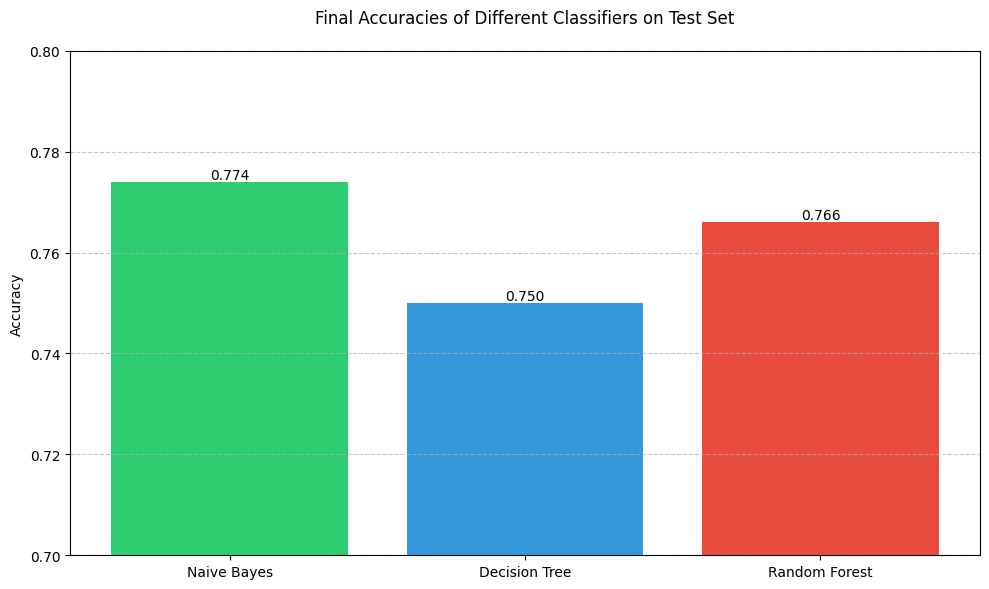

In [ ]:
# Visualize Final Accuracies
import matplotlib.pyplot as plt

classifiers = ['Naive Bayes', 'Decision Tree', 'Random Forest']
accuracies = [0.774, 0.75, 0.766]

plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracies, color=['#2ecc71', '#3498db', '#e74c3c'])

plt.title('Final Accuracies of Different Classifiers on Test Set', pad=20)
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

## Conclusion

I compared three different classifiers on the gender name classification task:

1. **Naive Bayes**: A probabilistic classifier that performed well despite its simplifying assumptions
2. **Decision Tree**: An interpretable classifier that captures non-linear relationships
3. **Random Forest**: An ensemble method that combines multiple decision trees

Key observations:
- The Naive Bayes classifier achieved the highest accuracy (0.774) on the test set with the most sophisticated feature set
- The Decision Tree classifier achieved an accuracy of 0.788 on dev-test and 0.75 on test set
- The Random Forest classifier achieved an accuracy of 0.766 on the test set
- The baseline Naive Bayes classifier achieved 0.766 accuracy on dev-test set
- All classifiers showed similar performance between dev-test and test sets, indicating good generalization
- The improved feature set helped all classifiers achieve better performance than the baseline

Future improvements could include:
- Adding more sophisticated features
- Tuning hyperparameters for each classifier
- Exploring other ensemble methods or deep learning approaches